# Nino calculations

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults
ps_defaults(use_tex=False, dpi=150)

## Introduction
https://ncar.github.io/PySpark4Climate/tutorials/Oceanic-Ni%C3%B1o-Index/
This notebook will introduce El Niño Index Calculation using PySpark to parallelize a number of tasks like computation of monthly averages for a given grid chunk, etc.

NOAA's operational definitions of El Niño and La Niña conditions are based upon the Oceanic Niño Index [ONI]. The ONI is defined as the 3-month running means of SST anomalies in the Niño 3.4 region [5N-5S, 120-170W].

The ONI is one measure of the El Niño-Southern Oscillation, and other indices can confirm whether features consistent with a coupled ocean-atmosphere phenomenon accompanied these periods.

## Computational Recipe
Compute area averaged total SST from Niño 3.4 region.
Compute monthly climatology (1854 - 2016) for area averaged total SST from Niño 3.4 region, and subtract climatology from area averaged total SST time series to obtain anomalies.
Smooth the anomalies with a 3-month running mean.


In [6]:
import os
import numpy as np
import xarray as xr
import dask
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from src.xr_utils import sel, open_dataset
from src.constants import OCEAN_DATA_PATH, OCEAN_OUTPUT_PATH

In [7]:
from src.data_loading.download import get_noaa_data

get_noaa_data()

Dowloading /home/users/sithom/seager19/src/data/NOAA_NCDC_ERSST_v3b_SST.nc


184959it [00:03, 51931.00it/s]


'get_zip'  4.81467 s 

'un_zip'  0.72239 s 

'clean_up'  0.01031 s 

'get_and_unzip'  5.54827 s 

/home/users/sithom/seager19/src/data/NOAA_NCDC_ERSST_v3b_SST.nc created.


In [21]:
from src.constants import NOAA_DATA_PATH
from src.xr_utils import sel, can_coords
from src.plot_utils import add_units, cmap

In [23]:
def load_noaa_data() -> xr.DataArray:
    noaa_da = add_units(can_coords(xr.open_dataarray(NOAA_DATA_PATH)))
    noaa_da.attrs["units"] = r"$^{\circ}$C"
    return noaa_da

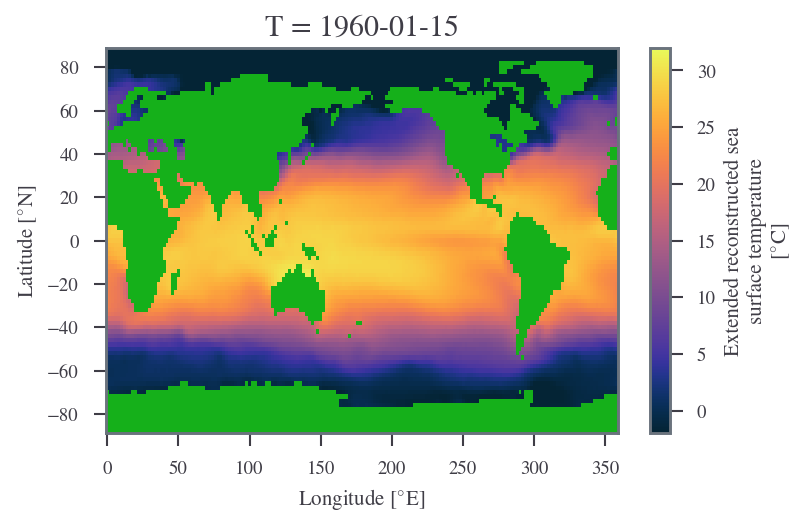

In [33]:
noaa_full = load_noaa_data()

noaa_full.isel(T=0).plot(cmap=cmap("sst"), vmin=-2, vmax=32)

In [26]:
len(noaa_full.coords["T"].values)

684

In [53]:
print(noaa_full.coords["T"].values[0])
print(noaa_full.coords["T"].values[-1])
# https://stackoverflow.com/questions/18215317/extracting-days-from-a-numpy-timedelta64-value
print((noaa_full.coords["T"].values[1]- noaa_full.coords["T"].values[0]).astype('timedelta64[D]'))

1960-01-15T00:00:00.000000000
2016-12-15T00:00:00.000000000
31 days


In [29]:
noaa_nino3_4_reg = sel(noaa_full, reg="nino3.4")

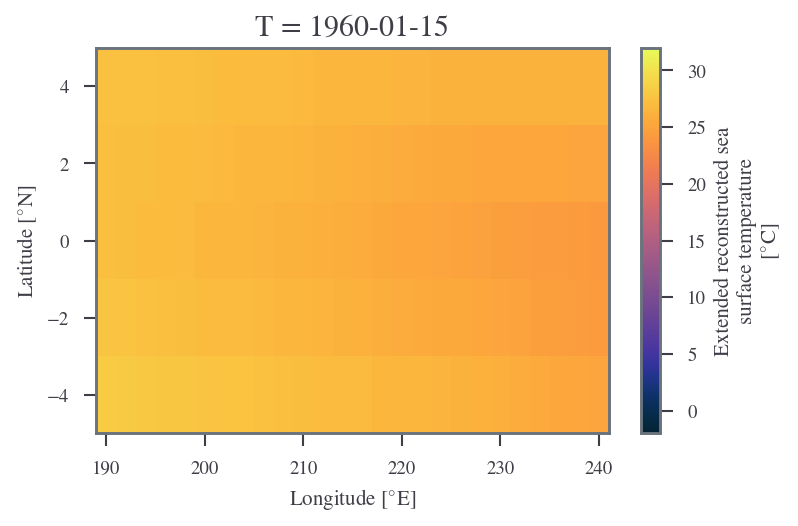

In [34]:
noaa_nino3_4_reg.isel(T=0).plot(cmap=cmap("sst"), vmin=-2, vmax=32)

In [4]:
# def get_region_of_interest(dset: xr.Dataset) -> xr.Dataset:
#     return dset.sel(lat=slice(-6, 6), lon=slice(190, 240))

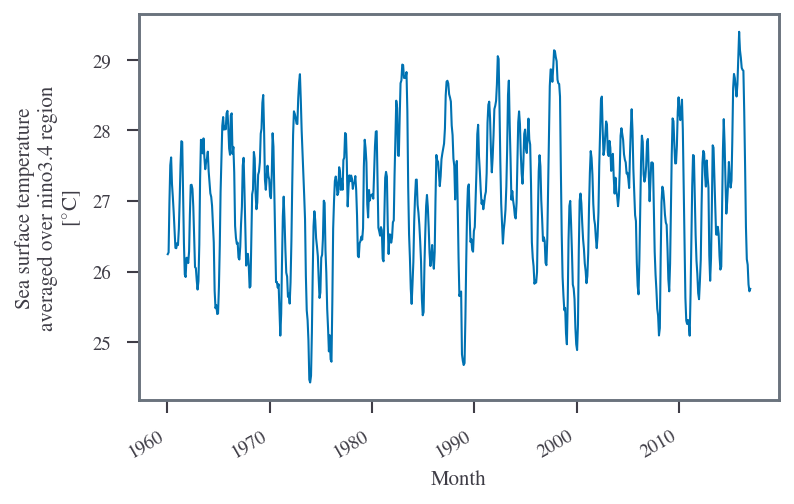

In [58]:
nino3_4_mean_timeseries = noaa_nino3_4_reg.mean(dim=["X", "Y"])
nino3_4_mean_timeseries.attrs["long_name"] = "Sea surface temperature averaged over nino3.4 region"
nino3_4_mean_timeseries.attrs["units"] = r"$^{\circ}$C"
nino3_4_mean_timeseries.coords["T"].attrs["long_name"] = "Month"
nino3_4_mean_timeseries.plot()

In [59]:
nino3_4_mean_state = nino3_4_mean_timeseries.mean(dim=["T"])
nino3_4_mean_timeseries.attrs["long_name"] = "Average sea surface temperature over nino3.4 region"
nino3_4_mean_timeseries.attrs["units"] = r"$^{\circ}$C"

In [60]:
print(nino3_4_mean_state)

<xarray.DataArray 'sst' ()>
array(27.035414, dtype=float32)


In [63]:
nino3_4_anomaly_timeseries = nino3_4_mean_timeseries - nino3_4_mean_state
nino3_4_anomaly_timeseries.attrs["long_name"] = "Sea surface temperature averaged over nino3.4 region"
nino3_4_anomaly_timeseries.attrs["units"] = r"$^{\circ}$C"

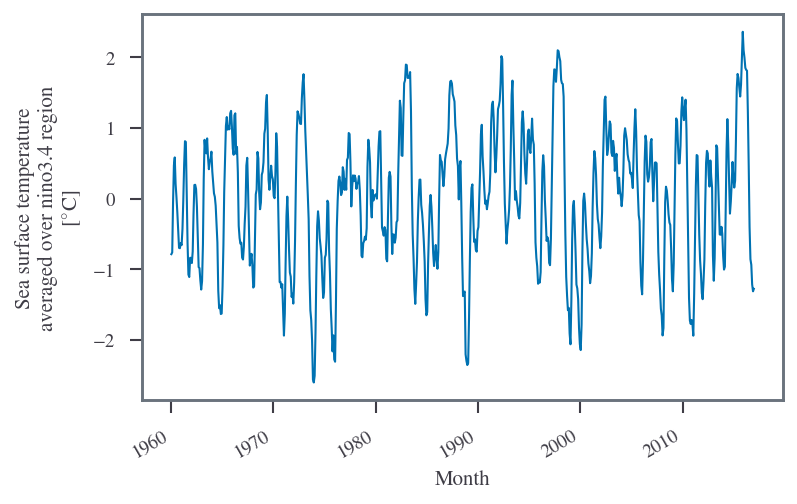

In [64]:
nino3_4_anomaly_timeseries.plot()

In [85]:
nino3_4_metric = nino3_4_anomaly_timeseries.rolling(min_periods=1, T=3, center=True).mean()
nino3_4_metric.attrs["long_name"] = "3 month rolling average of sea surface temperature averaged over nino3.4 region"
nino3_4_metric.attrs["units"] = r"$^{\circ}$C"
nino3_4_metric.attrs["rolling_average"] = "3 months"

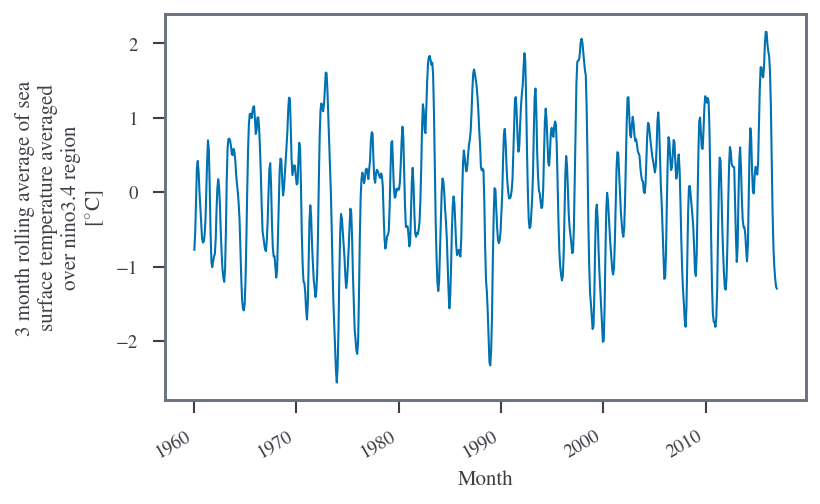

In [86]:
nino3_4_metric.plot()

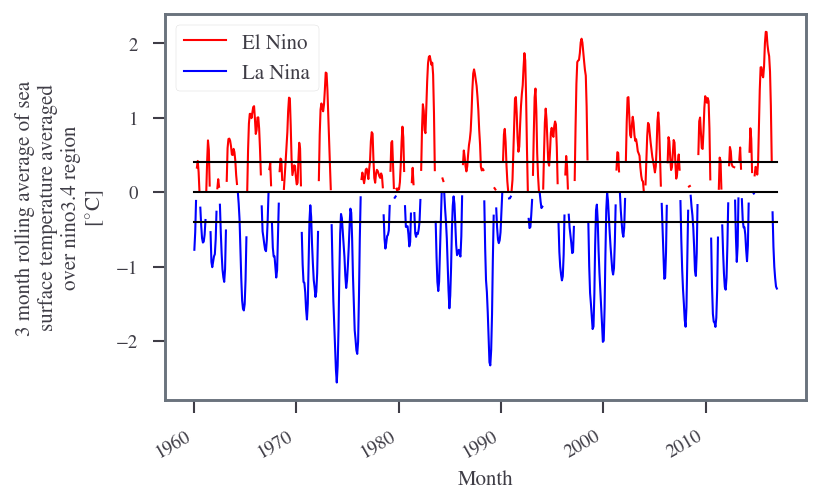

In [84]:
nino3_4_metric.where(nino3_4_metric>=0).plot(color="red", label="El Nino")
nino3_4_metric.where(nino3_4_metric<=0).plot(color="blue", label=r"La Nina")
dummy_line = nino3_4_metric.copy()
dummy_line[:] = 0
dummy_line.plot(color="black")
dummy_line[:] = 0.4
dummy_line.plot(color="black")
dummy_line[:] = -0.4
dummy_line.plot(color="black")
plt.legend()

In [90]:
from src.constants import NINO3_4_TEST_PATH

In [91]:
nino3_4_metric.to_netcdf(str(NINO3_4_TEST_PATH))

In [88]:
open_dataset(OCEAN_OUTPUT_PATH / "om_run2f.nc").SST_SST

<xarray.DataArray 'SST_SST' (T_03: 697, L_03: 1, Y_03: 161, X_03: 360)>
[40398120 values with dtype=float32]
Coordinates:
  * X_03     (X_03) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y_03     (Y_03) float32 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * L_03     (L_03) float32 1.0
  * T_03     (T_03) object 1957-12-30 10:59:51.650391 ... 2015-12-28 16:53:33...
Attributes:
    long_name:  SST

In [19]:
print(open_dataset(OCEAN_OUTPUT_PATH / "om_spin.nc"))

<xarray.Dataset>
Dimensions:       (GRID: 1, L_01: 1, L_02: 1, L_03: 1, T_01: 241, T_02: 241, T_03: 241, X_01: 161, X_02: 360, X_03: 360, Y_01: 360, Y_02: 161, Y_03: 161)
Coordinates: (12/13)
  * GRID          (GRID) float32 0.0
  * X_01          (X_01) float32 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * Y_01          (Y_01) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * L_01          (L_01) float32 1.0
  * T_01          (T_01) object 1937-12-30 10:59:31.875000 ... 1957-12-28 16:...
  * X_02          (X_02) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    ...            ...
  * L_02          (L_02) float32 0.0
  * T_02          (T_02) object 1937-12-30 10:59:31.875000 ... 1957-12-28 16:...
  * X_03          (X_03) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y_03          (Y_03) float32 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * L_03          (L_03) float32 1.0
  * T_03          (T_03) object 1937-12-30 10:59:31.875000 ... 1957-12

In [5]:
def global_mean_sst(dset: xr.Dataset) -> xr.Dataset:
    # Find mean temperature for each latitude
    mean_sst_lat = dset.sst.mean(dim='lon')

    # Find Weighted mean of those values
    num =(np.cos(dset.lat) * mean_sst_lat).sum(dim='lat')
    denom = np.sum(np.cos(dset.lat))

    # Find mean global temperature
    mean_global_temp = num / denom

    return mean_global_temp

In [ ]:
rdd = reader.nc_multi_read(sc, paths, data_splitting_mode="slice")
region_of_interest = rdd.map(get_region_of_interest).cache()
mean_global_temp = region_of_interest.map(global_mean_sst)
mean_sst = mean_global_temp.collect()
a = xr.concat(mean_sst[:1956], dim="time")

In [ ]:
ds = a.to_dataset(name="mean_sst")
climatology = ds.groupby('time.month').mean('time')
climatology
anomalies = ds.groupby('time.month') - climatology
anomalies